In [16]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import sys
import os
for dirname, _, filenames in os.walk('./archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')

# Replace these values with your actual database information
hostname = "gator3228.hostgator.com"
username = "rbrennan_sm_bcd"
password = "This_is_not_the_password"
database = "rbrennan_stock_project_4"
# Create a database connection
db_url = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{database}"
engine = create_engine(db_url)
# Test the connection
try:
    conn = engine.connect()
    print("Connected to MySQL database")
except Exception as e:
    print("Error:", e)
amzn_data = pd.read_sql("SELECT * FROM Amazon", conn)
amzn_data

Exception during reset or similar
Traceback (most recent call last):
  File "c:\Users\bchau\anaconda3\envs\dev\lib\site-packages\sqlalchemy\pool\base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "c:\Users\bchau\anaconda3\envs\dev\lib\site-packages\sqlalchemy\pool\base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "c:\Users\bchau\anaconda3\envs\dev\lib\site-packages\sqlalchemy\engine\default.py", line 682, in do_rollback
    dbapi_connection.rollback()
  File "c:\Users\bchau\anaconda3\envs\dev\lib\site-packages\mysql\connector\connection_cext.py", line 517, in rollback
    self._cmysql.rollback()
_mysql_connector.MySQLInterfaceError: Lost connection to MySQL server during query


Connected to MySQL database


,Date,Open,High,Low,Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,99100000
...,...,...,...,...,...,...
1399,2023-09-12,142.320007,143.000000,140.610001,141.229996,42668500
1400,2023-09-13,140.949997,144.979996,140.869995,144.850006,60465200
1401,2023-09-14,145.080002,145.860001,142.949997,144.720001,64033600
1402,2023-09-15,142.690002,143.570007,140.089996,140.389999,102861700


In [13]:
amzn_info = amzn_data.info()
print(amzn_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1404 non-null   datetime64[ns]
 1   Open    1404 non-null   float64       
 2   High    1404 non-null   float64       
 3   Low     1404 non-null   float64       
 4   Close   1404 non-null   float64       
 5   Volume  1404 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 65.9 KB
None


In [15]:
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])
amzn_data.set_index('Date', inplace=True)

In [18]:
# list columns
amzn_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [22]:
# check for missing values
missing_values = amzn_data.isnull().sum()
print(missing_values)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [23]:
summary_stats = amzn_data.describe().T
print(summary_stats)

         count          mean           std           min           25%  \
Open    1404.0  1.204012e+02  3.339273e+01  6.730000e+01  9.099237e+01   
High    1404.0  1.218659e+02  3.373689e+01  6.980150e+01  9.166037e+01   
Low     1404.0  1.188021e+02  3.299514e+01  6.535000e+01  9.000875e+01   
Close   1404.0  1.203472e+02  3.332554e+01  6.719800e+01  9.087063e+01   
Volume  1404.0  8.262410e+07  3.887208e+07  1.762600e+07  5.643655e+07   

                 50%           75%           max  
Open    1.112000e+02  1.563623e+02  1.872000e+02  
High    1.139113e+02  1.583836e+02  1.886540e+02  
Low     1.086100e+02  1.543006e+02  1.848395e+02  
Close   1.111387e+02  1.558640e+02  1.865705e+02  
Volume  7.130300e+07  9.760650e+07  3.113460e+08  


In [28]:
# calculate 50 day moving average as extra feature
amzn_data['50_day_MA'] = amzn_data['Close'].rolling(window=50).mean()

In [29]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# calculate RSI
amzn_data['RSI'] = calculate_rsi(amzn_data)

In [30]:
# train test split data
from sklearn.model_selection import train_test_split

# features and target variable
features = ['Open', 'High', 'Low', 'Volume', '50_day_MA']
target = 'Close'

# split data into train and test sets
train_data, test_data = train_test_split(amzn_data, test_size=0.2, shuffle=False)

In [31]:
# testing arima model
from statsmodels.tsa.arima.model import ARIMA

In [32]:
# train arima model
arima_model =ARIMA(train_data[target], order=(5, 1, 1))

# fit the arima model
arima_fit = arima_model.fit()

In [33]:
# evaluate the model
from sklearn.metrics import mean_squared_error

predictions = arima_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data[target], predictions)
print(mse)

1160.1154024362775


Text(0.5, 1.0, 'Actual vs. Predicted Prices')

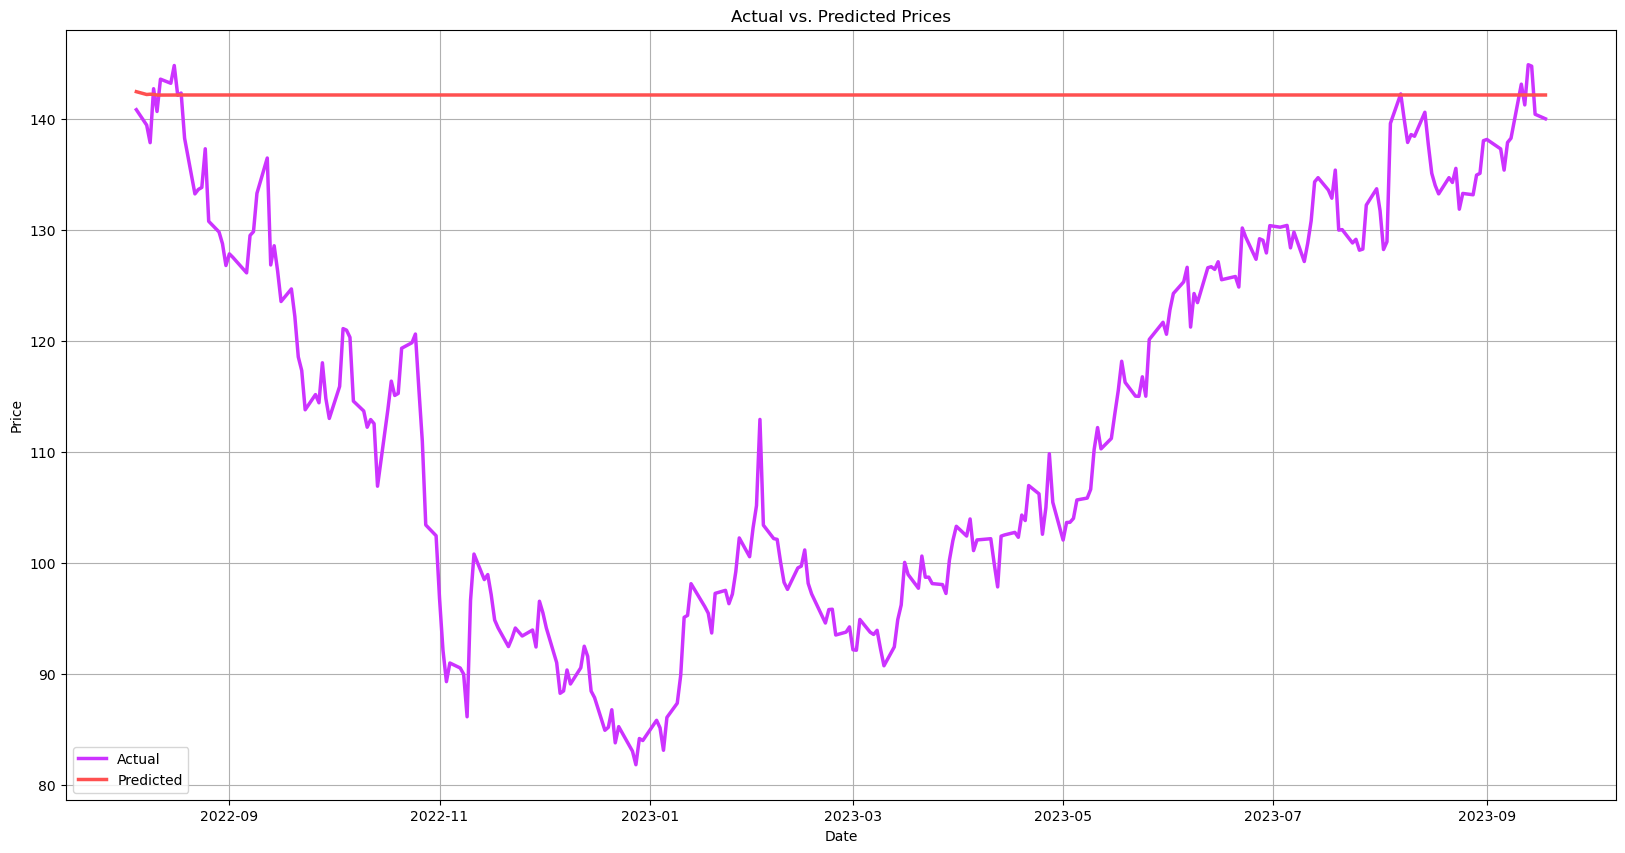

In [34]:
plt.figure(figsize=(20,10))
plt.plot(test_data['Date'], test_data[target], label='Actual', color="#cc33ff", linewidth='2.5')   
plt.plot(test_data['Date'], predictions, label='Predicted', color="#ff5050", linewidth='2.5')
plt.grid(True)   
plt.legend()                                                     
plt.xlabel('Date')                                             
plt.ylabel('Price')                                       
plt.title('Actual vs. Predicted Prices')                 

In [35]:
# xgboost model
import xgboost as xgb

# features and target variable
features = ['Open', 'High', 'Low', 'Volume', '50_day_MA', 'RSI']
target = 'Close'

# create DMatrix for XGBoost
train_dmatrix = xgb.DMatrix(data=train_data[features], label=train_data[target])

# xgboost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 30,
    'learning_rate': 0.3
}

# train xgboost model
xgb_model = xgb.train(params=params, dtrain=train_dmatrix)

In [36]:
# create test data
test_dmatrix = xgb.DMatrix(data=test_data[features], label=test_data[target])

# Use the trained XGBoost model to make predictions
xgb_predictions = xgb_model.predict(test_dmatrix)

# Calculate Mean Squared Error
mse_xgb = mean_squared_error(test_data[target], xgb_predictions)
print(mse_xgb)

3.266334843254623


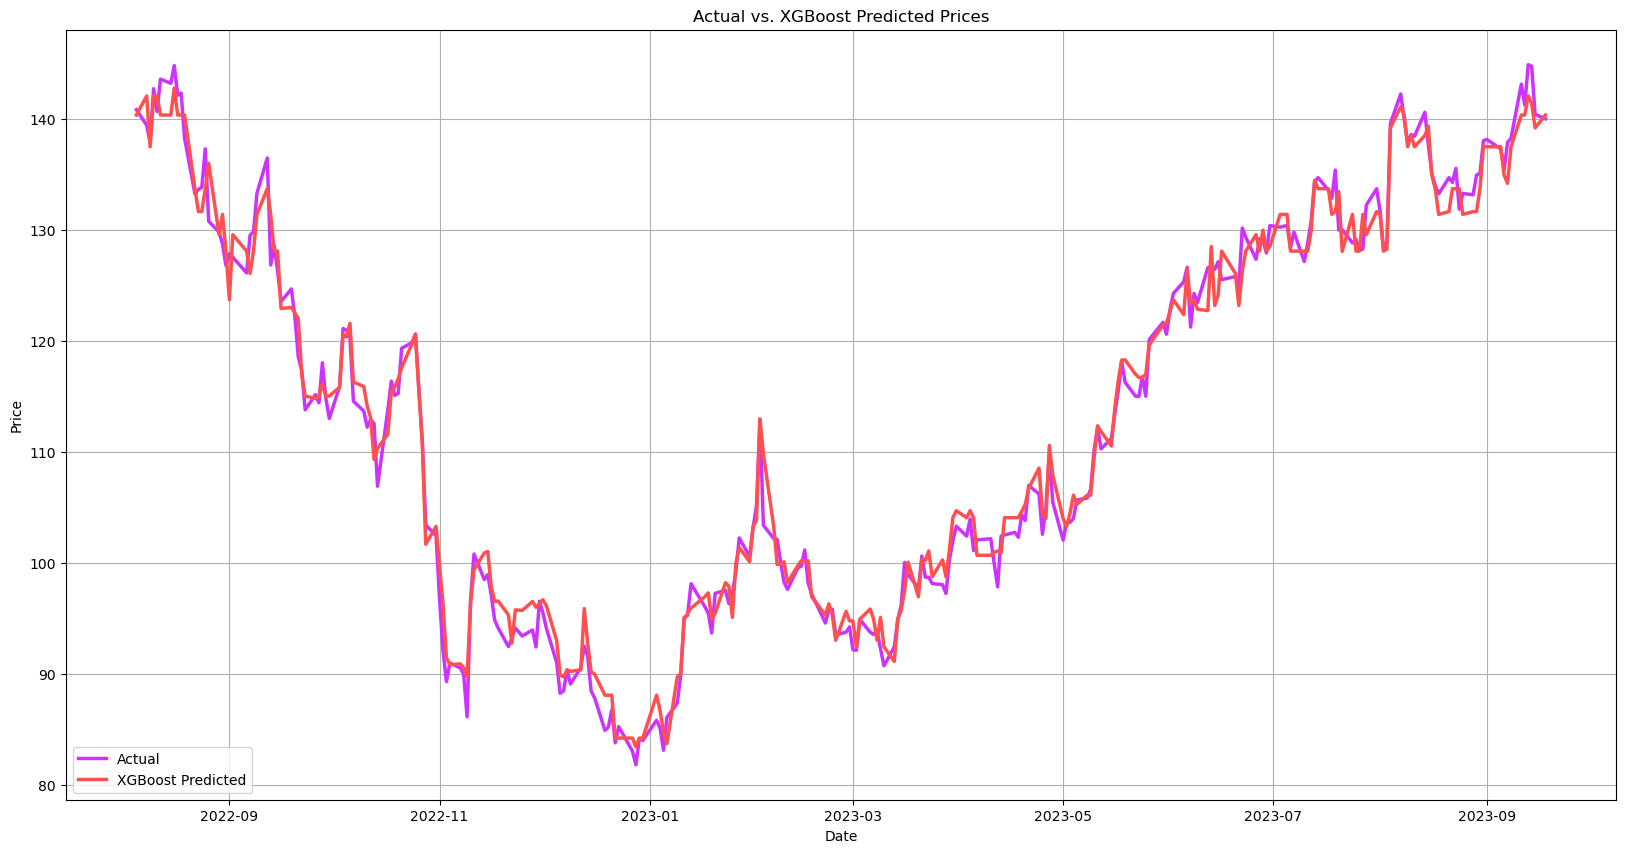

In [37]:
plt.figure(figsize=(20,10))
plt.plot(test_data['Date'], test_data[target], label='Actual', color="#cc33ff", linewidth='2.5')
plt.plot(test_data['Date'], xgb_predictions, label='XGBoost Predicted', color="#ff5050", linewidth='2.5')
plt.grid(True)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. XGBoost Predicted Prices')
plt.show()

In [67]:
# predict future prices with trained model
# date range for future predictions
#future_dates = pd.date_range(start=test_data['Date'].iloc[-1], periods=30, freq='D')
#print(future_dates)

# future prediction dates df
#future_df = pd.DataFrame({'ds': future_dates})
#print(future_df)

DatetimeIndex(['2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25',
               '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29',
               '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03',
               '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07',
               '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11',
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17'],
              dtype='datetime64[ns]', freq='D')


In [68]:
# predict future dates with xgboost model
#future_dmatrix = xgb.DMatrix(data=future_df[features])
#future_predictions = xgb_model.predict(future_dmatrix)


In [69]:
# second test with linear regression
#test_pred = test_data.copy()

In [70]:
#train_data.head(10)

,Date,Open,High,Low,Close,Volume,50_day_MA,RSI
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,129984000,NaN,NaN
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,126088000,NaN,100.000000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,97162000,NaN,100.000000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,88362000,NaN,100.000000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,99100000,NaN,100.000000
5,2018-02-27,76.224998,76.338997,75.360497,75.598999,96176000,NaN,84.316374
6,2018-02-28,75.975502,76.434998,75.599998,75.622498,90300000,NaN,84.431473
7,2018-03-01,75.680000,75.924500,73.250000,74.672501,136704000,NaN,65.113167
8,2018-03-02,73.455002,75.052498,72.750504,75.012497,131752000,NaN,67.753726
9,2018-03-05,74.711998,76.268997,74.050003,76.180496,104678000,NaN,74.408078


In [71]:
#test_data.head(10)

,Date,Open,High,Low,Close,Volume,50_day_MA,RSI
1123,2022-08-05,140.100006,142.860001,139.600006,140.800003,50686900,117.13047,75.664391
1124,2022-08-08,142.050003,144.229996,138.289993,139.410004,52229000,117.78317,71.362359
1125,2022-08-09,138.050003,138.949997,136.210007,137.830002,40434700,118.31822,66.144944
1126,2022-08-10,142.899994,144.600006,141.009995,142.690002,54773800,118.86909,68.190979
1127,2022-08-11,143.860001,144.490005,139.759995,140.639999,44867300,119.27770,68.411478
1128,2022-08-12,142.050003,143.570007,140.119995,143.550003,47643500,119.71502,71.923301
1129,2022-08-15,142.800003,143.759995,141.490005,143.179993,39014600,120.06840,81.417477
1130,2022-08-16,143.910004,146.570007,142.000000,144.779999,59102900,120.51700,79.329864
1131,2022-08-17,142.690002,143.380005,140.779999,142.100006,48149800,120.86320,73.617729
1132,2022-08-18,141.320007,142.770004,140.380005,142.300003,37458700,121.24920,62.461854


In [72]:
#x_train = train_data[['Open', 'High', 'Low', 'Volume']].values
#x_test = test_data[['Open', 'High', 'Low', 'Volume']].values

In [73]:
#y_train = train_data['Close'].values
#y_test = test_data['Close'].values

In [74]:
#model_lnr = LinearRegression()
#model_lnr.fit(x_train, y_train)

LinearRegression()

In [75]:
#y_pred = model_lnr.predict(x_test)